In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.6.5


In [4]:
# Create a list with the filepaths for training and testing
train_dir = Path('dataset/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [5]:
test_dir = Path('dataset/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [6]:
val_dir = Path('dataset/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [7]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [8]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [9]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 3159

Number of different labels: 42

Labels: ['eggplant' 'mango' 'persimmon' 'tomato' 'pomegranate' 'capsicum'
 'beetroot' 'pineapple' 'pumpkin' 'sweetcorn' 'pear' 'coconut' 'raddish'
 'kiwi' 'custard apple' 'garlic' 'cabbage' 'soy beans' 'peas' 'paprika'
 'spinach' 'banana' 'watermelon' 'grapes' 'turnip' 'lettuce' 'ginger'
 'cauliflower' 'bell pepper' 'chilli pepper' 'wintermelon' 'cucumber'
 'guava' 'jalepeno' 'apple' 'potato' 'carrot' 'corn' 'lemon' 'sweetpotato'
 'orange' 'onion']


In [10]:
train_df.head(5)

,Filepath,Label
0,dataset/train/eggplant/Image_30.jpg,eggplant
1,dataset/train/mango/Image_31.jpg,mango
2,dataset/train/persimmon/Image_69.jpg,persimmon
3,dataset/train/tomato/Image_10.jpg,tomato
4,dataset/train/pomegranate/Image_27.jpg,pomegranate


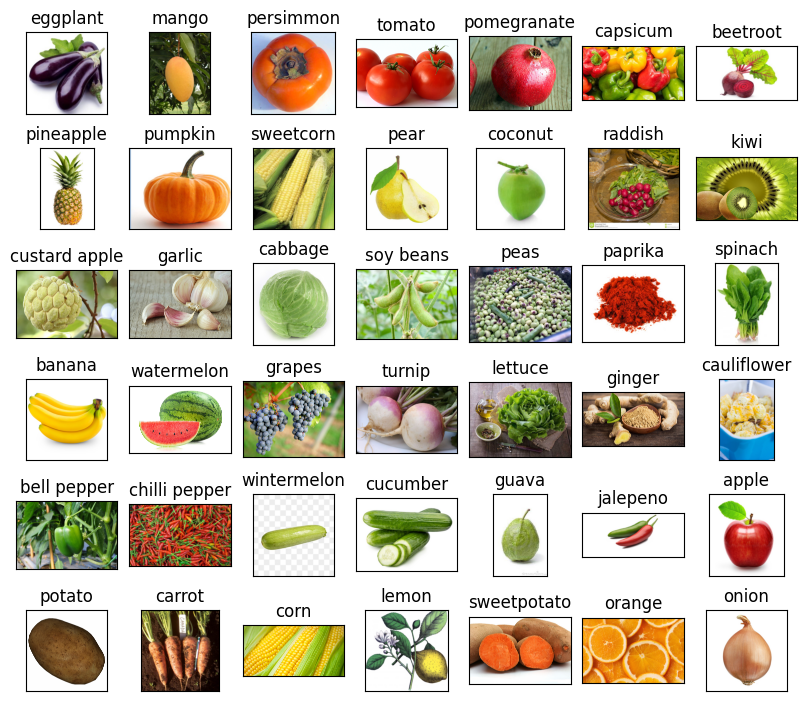

In [11]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=7, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [12]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [13]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 3159 validated image filenames belonging to 42 classes.


In [14]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 368 validated image filenames belonging to 42 classes.


In [15]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 368 validated image filenames belonging to 42 classes.


In [16]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
    
)
pretrained_model.trainable = False

2022-12-15 21:18:57.495370: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(42, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

2022-12-15 21:19:03.361518: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
99/99 [==============================] - 459s 5s/step - loss: 1.8293 - accuracy: 0.5290 - val_loss: 0.4968 - val_accuracy: 0.8424
Epoch 2/5
99/99 [==============================] - 415s 4s/step - loss: 0.5354 - accuracy: 0.8386 - val_loss: 0.3088 - val_accuracy: 0.9212
Epoch 3/5
99/99 [==============================] - 433s 4s/step - loss: 0.3191 - accuracy: 0.8943 - val_loss: 0.2464 - val_accuracy: 0.9293
Epoch 4/5
99/99 [==============================] - 417s 4s/step - loss: 0.2019 - accuracy: 0.9392 - val_loss: 0.2382 - val_accuracy: 0.9321
Epoch 5/5
99/99 [==============================] - 481s 5s/step - loss: 0.1345 - accuracy: 0.9569 - val_loss: 0.1836 - val_accuracy: 0.9538


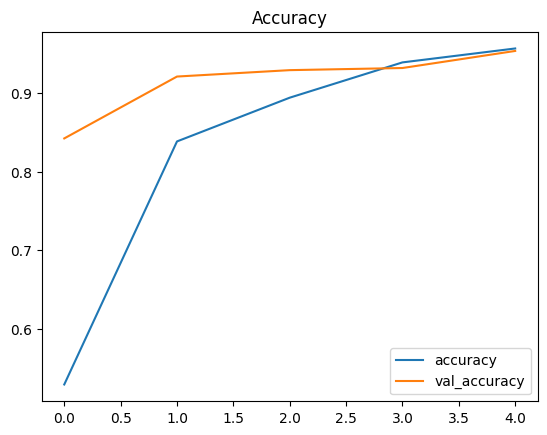

In [18]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()  # we are plotting the train and validation accuracy to check on if its overfitting 
plt.title('Accuracy')
plt.show()

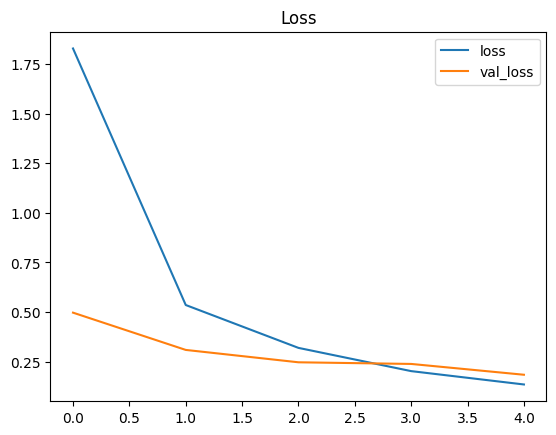

In [19]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Loss')
plt.show()

In [20]:
pred = model.predict(test_images) #its predicting time , our model will try to predict the prob of the particular class 
pred = np.argmax(pred, axis=1) 
labels = (train_images.class_indices) #this gives us the labels with indicies to map

labels = dict((v,k) for k,v in labels.items()) 
pred = [labels[k] for k in pred] #we are iterating over the pred and taking the label for that particualar value

y_test = [labels[k] for k in test_images.classes] 

In [21]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 95.38%


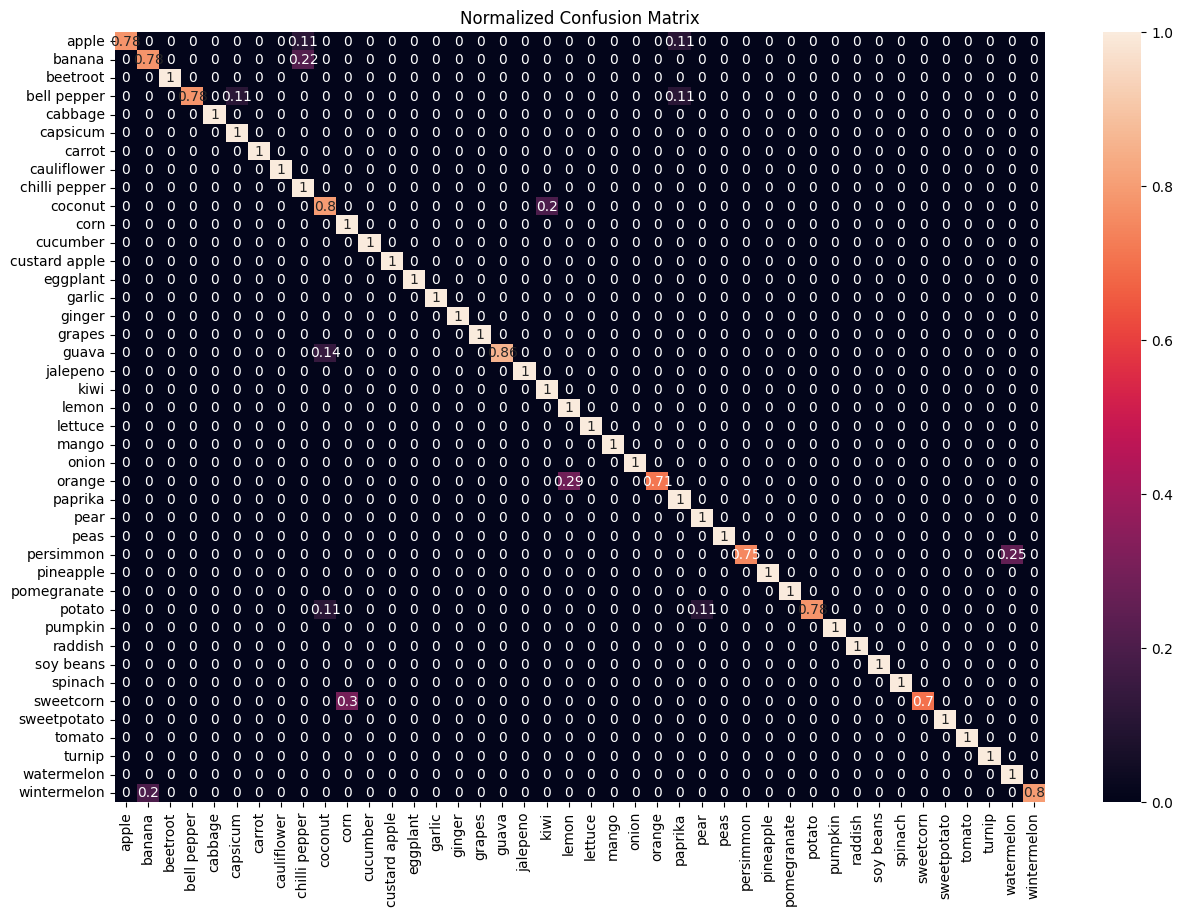

In [22]:
from sklearn.metrics import confusion_matrix #lets visualise the model predictions 
import seaborn as sns
cf_matrix = confusion_matrix(y_test, pred, normalize='true')  
plt.figure(figsize=(15,10))
sns.heatmap(cf_matrix, annot=True,
            xticklabels = sorted(set(y_test)), #we put this to see labels
            yticklabels = sorted(set(y_test))
           )
plt.title('Normalized Confusion Matrix')
plt.show()

In [23]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

['peas',
 'wintermelon',
 'carrot',
 'spinach',
 'capsicum',
 'turnip',
 'sweetcorn',
 'turnip',
 'raddish',
 'sweetpotato',
 'pomegranate',
 'eggplant',
 'custard apple',
 'paprika',
 'eggplant',
 'corn',
 'pear',
 'cabbage',
 'sweetcorn',
 'paprika',
 'kiwi',
 'pear',
 'mango',
 'raddish',
 'lettuce',
 'pear',
 'cabbage',
 'pineapple',
 'peas',
 'mango',
 'guava',
 'cabbage',
 'ginger',
 'kiwi',
 'grapes',
 'paprika',
 'soy beans',
 'lemon',
 'tomato',
 'pear',
 'cucumber',
 'ginger',
 'corn',
 'eggplant',
 'paprika',
 'turnip',
 'pomegranate',
 'raddish',
 'pomegranate',
 'wintermelon',
 'pomegranate',
 'cabbage',
 'mango',
 'corn',
 'chilli pepper',
 'apple',
 'cabbage',
 'watermelon',
 'orange',
 'bell pepper',
 'custard apple',
 'sweetpotato',
 'potato',
 'sweetpotato',
 'beetroot',
 'potato',
 'beetroot',
 'garlic',
 'lemon',
 'garlic',
 'grapes',
 'tomato',
 'coconut',
 'pomegranate',
 'banana',
 'raddish',
 'jalepeno',
 'spinach',
 'potato',
 'soy beans',
 'paprika',
 'caulifl

In [24]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [25]:
img = output('dataset/test/cabbage/Image_1.jpg')
img

'cabbage'

In [26]:
model.save('FV.h5')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
